In [45]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, MixedDataLoader

####

from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence
from itertools import combinations

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt


data_dir = "data"
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Data resides in        : {data_dir}")
print(f"Model will be saved to : {model_dir}")

Data resides in        : data
Model will be saved to : models


In [40]:
class RBM(nn.Module):
    num_visible: int
    num_hidden: int
    k: int = 1
    T: float = 1.0

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.num_visible, self.num_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.num_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.num_hidden,))

    def __call__(self, data: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, self.b, self.c, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (aux_vars["gibbs_chain"], aux_vars["key"]))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain)

        free_energy_data = self._free_energy(data)
        free_energy_model = self._free_energy(gibbs_chain)

        contrastive_divergence = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        regularization = aux_vars["l2_strength"] * (jnp.sum(self.W**2) + jnp.sum(self.b**2) + jnp.sum(self.c**2))
        loss = contrastive_divergence + regularization

        aux_vars = {
            "gibbs_chain": gibbs_chain,
            "key": key,
            "free_energy_data": jnp.mean(free_energy_data),
            "free_energy_model": jnp.mean(free_energy_model),
        }

        return loss, aux_vars

    def _free_energy(self, v):
        return -(v @ self.b) - jnp.sum(jax.nn.softplus(v @ self.W + self.c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    @nn.nowrap
    def generate(self, num_samples: int, T_schedule: jnp.ndarray, key: PRNGKey) -> jnp.ndarray:
        key, key_init = jax.random.split(key, 2)
        v = jax.random.bernoulli(key_init, p=0.5, shape=(num_samples, self.num_visible)).astype(jnp.float32)

        anneal_fn = lambda i, s: self._gibbs_step(s, W=self.W, b=self.b, c=self.c, T=T_schedule[i])
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), anneal_fn, (v, key))
        return v_final

In [41]:
@jax.jit
def train_step(
        state: TrainState,
        batch: jnp.ndarray,
        gibbs_chain: jnp.ndarray,
        key: PRNGKey,
        chain_reset_frac: float,
        l2_strength) -> Tuple[TrainState, jnp.ndarray, jnp.ndarray, PRNGKey]:

    key, key_reset = jax.random.split(key)

    # reset gibbs_chain[i] with batch[i] given reset probability as chain_reset_frac
    reset_mask = jax.random.bernoulli(key_reset, p=chain_reset_frac, shape=(batch.shape[0], 1))
    gibbs_chain = jnp.where(reset_mask, batch, gibbs_chain)

    aux_vars = {"gibbs_chain": gibbs_chain, "key": key, "l2_strength": l2_strength}
    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss, aux_vars["gibbs_chain"], aux_vars["key"], aux_vars["free_energy_model"]


def count_modes(chain: jnp.ndarray) -> int:
    chain = chain.astype(jnp.uint32)
    powers = 2 ** jnp.arange(chain.shape[-1], dtype=jnp.uint32)
    ints = jnp.dot(chain, powers)

    hist = jnp.bincount(ints, length=1 << chain.shape[-1])
    return int(jnp.sum(hist > 0))


def train(
        state: TrainState,
        loader: MixedDataLoader,
        num_epochs: int,
        key: PRNGKey,
        chain_reset_frac: float,
        l2_strength: float) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    for epoch in range(num_epochs):
        gibbs_chain = None
        tot_loss = 0.0

        for i, batch in enumerate(loader):
            measurements = batch[:, :, 0].astype(jnp.float32) # we simply assume we are only dealing with Z-basis measurements here
            gibbs_chain = measurements if gibbs_chain is None else gibbs_chain

            key, key_batch = jax.random.split(key)
            state, loss, gibbs_chain, key, free_energy_model = train_step(state, measurements, gibbs_chain, key, chain_reset_frac, l2_strength)

            tot_loss += float(loss)

        avg_loss = tot_loss / len(loader)
        modes = count_modes(gibbs_chain)
        lr = float(lr_schedule(state.opt_state[0].count))

        metrics[epoch] = dict(loss=avg_loss, modes=modes, free_energy_model=free_energy_model, lr=lr)

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Chain Modes: {modes} │ "
              f"Free Energy Model: {free_energy_model:.4f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [42]:
file_path = Path("data/w_aug_ZZZZZZZZ_10000.txt")
data = load_measurements(file_path)

measurements = data[:, :, 0]
empirical_freq = measurements.mean(axis=0)
empirical_freq

Parsing measurements: 100%|██████████| 10000/10000 [00:00<00:00, 26477.45it/s]


Array([0.12529999, 0.1228    , 0.1222    , 0.1248    , 0.1337    ,
       0.1295    , 0.1199    , 0.1218    ], dtype=float32)

In [44]:
batch_size   = 1024             # larger requires more epochs for the model to go down in its modes
num_visible  = 8
hidden_units = 8                # interesting, lower gives evener frequencies, although the modes go not down to 1
k_steps      = 50               # more steps required if small batch size
num_epochs   = 2000             # longer since large batch size
init_lr      = 1e-2             # large drives modes down fast but learns nothing, to small and we dont get any one hots
final_lr     = init_lr * 0.1
chain_reset_frac = 0.1
l2_strength  = 1e-4

# runs also very nicely if l2 norm is turned off completely


key_seed = PRNGKey(42)
key, key_params, key_dummy = jax.random.split(key_seed, 3)

model = RBM(num_visible=num_visible, num_hidden=hidden_units, k=k_steps)
batch_dummy = jnp.zeros((batch_size, num_visible), dtype=jnp.float32)
aux_vars_dummy = {"gibbs_chain": jnp.zeros((batch_size, num_visible), dtype=jnp.float32), "key": key_dummy, "l2_strength": l2_strength}
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader = MixedDataLoader(data, batch_size=batch_size, drop_last=True) # we need the last batch to match the chain dimension

schedule_steps = num_epochs * len(loader)
lr_schedule = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optimizer = optax.adam(lr_schedule)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optimizer)

state, metrics = train(state, loader, num_epochs, key, chain_reset_frac, l2_strength)

Epoch 1/2000 │ Loss: -0.4583 │ Chain Modes: 243 │ Free Energy Model: -4.5385 │ Learning Rate: 0.00990
Epoch 2/2000 │ Loss: -1.0704 │ Chain Modes: 212 │ Free Energy Model: -4.1756 │ Learning Rate: 0.00990
Epoch 3/2000 │ Loss: -1.1997 │ Chain Modes: 195 │ Free Energy Model: -4.2334 │ Learning Rate: 0.00990
Epoch 4/2000 │ Loss: -1.0315 │ Chain Modes: 152 │ Free Energy Model: -4.6784 │ Learning Rate: 0.00990
Epoch 5/2000 │ Loss: -0.7388 │ Chain Modes: 148 │ Free Energy Model: -5.0193 │ Learning Rate: 0.00990
Epoch 6/2000 │ Loss: -0.4145 │ Chain Modes: 121 │ Free Energy Model: -5.6295 │ Learning Rate: 0.00990
Epoch 7/2000 │ Loss: -0.1757 │ Chain Modes: 112 │ Free Energy Model: -5.8853 │ Learning Rate: 0.00990
Epoch 8/2000 │ Loss: -0.0912 │ Chain Modes: 112 │ Free Energy Model: -6.1150 │ Learning Rate: 0.00990
Epoch 9/2000 │ Loss: +0.0012 │ Chain Modes: 103 │ Free Energy Model: -6.2427 │ Learning Rate: 0.00990
Epoch 10/2000 │ Loss: -0.0398 │ Chain Modes: 109 │ Free Energy Model: -6.3900 │ Le

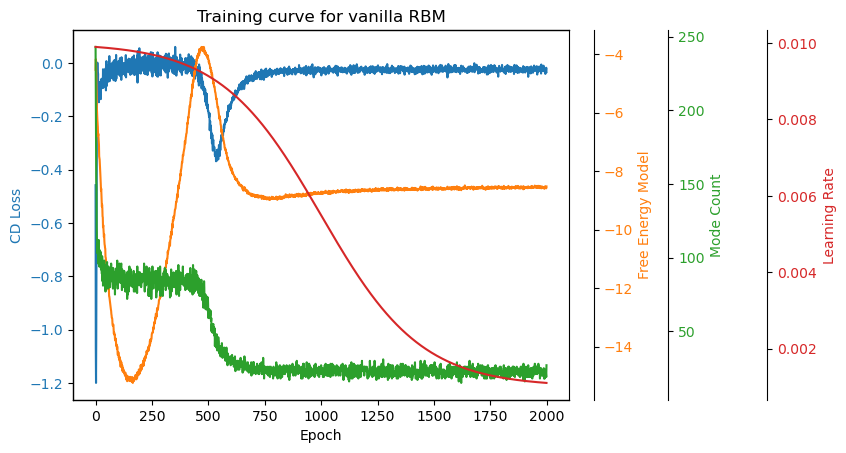

In [47]:
epochs = list(metrics.keys())

loss_vals = [metrics[e]['loss'] for e in epochs]
mode_vals = [metrics[e]['modes'] for e in epochs]
free_energy_model_vals = [metrics[e]['free_energy_model'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_ylabel("CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.05))
ax2.plot(epochs, free_energy_model_vals, label="Free Energy Model", color="tab:orange")
ax2.set_ylabel("Free Energy Model", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(epochs, mode_vals, color="tab:green")
ax3.set_ylabel("Mode Count", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.4))
ax4.plot(epochs, lr_vals,color="tab:red")
ax4.set_ylabel("Learning Rate", color="tab:red")
ax4.tick_params(axis="y", labelcolor="tab:red")

plt.title("Training curve for vanilla RBM")
plt.show()

In [49]:
# shifting the center step to 0 we can approximate an exponential schedule if we choose the high to be
T_high = 2.0
T_low = 0.01
sampling_steps = 5_000
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

key_sample = PRNGKey(1234)

samples = model.apply(
    {"params": state.params},
    num_samples=10_000,
    T_schedule=sigmoid_schedule,
    key=key_sample,
    method=RBM.generate
)

sampled_freq = samples.mean(0)
sampled_freq

Array([0.1286    , 0.1371    , 0.1169    , 0.1074    , 0.1397    ,
       0.1319    , 0.11629999, 0.1221    ], dtype=float32)

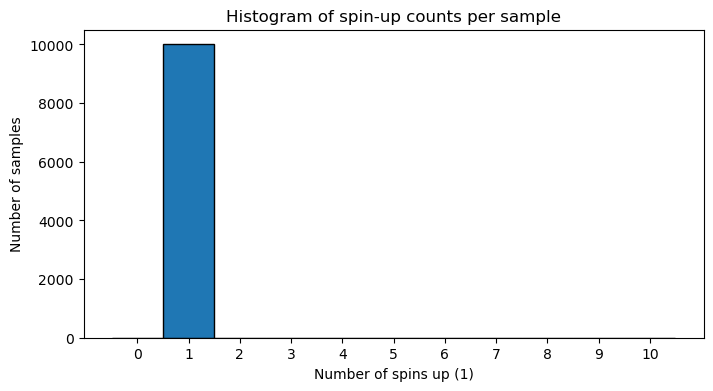

In [50]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

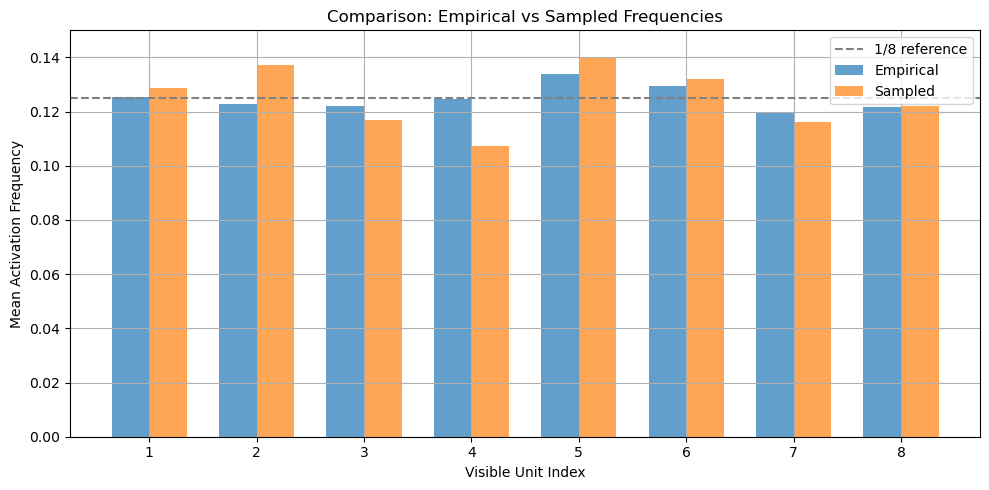

In [52]:
plt.figure(figsize=(10, 5))
x = jnp.arange(num_visible) + 1

width = 0.35

plt.bar(x - width/2, empirical_freq, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, sampled_freq, width, label="Sampled", alpha=0.7)

plt.axhline(1 / num_visible, linestyle='--', color='gray', label=f'1/{num_visible} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Frequency")
plt.ylim(0, 0.15)
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# during phase training we will at most encounter k-hot vectors with k <= 3

def make_k_hot(n, k):
    return jnp.array([jnp.array([1 if i in idxs else 0 for i in range(n)]) for idxs in combinations(range(n), k)], dtype=jnp.float32)

k_hot_vectors = jnp.concatenate([make_k_hot(num_visible, k) for k in range(4)], axis=0)

fe_k_hot = model.apply({'params': state.params}, method=model._free_energy, v=k_hot_vectors)
fe_k_hot = jnp.squeeze(fe_k_hot)
min_fe_k_hot = jnp.min(fe_k_hot)
max_fe_k_hot = jnp.max(fe_k_hot)

print(f"min energy: {min_fe_k_hot:6f}, max energy: {max_fe_k_hot:6f}")

min energy: -8.730392, max energy: 3.766863
